# Proyecto 04

Te presentamos los pasos a seguir para realizar el proyecto 04.

1. Elige tu punto de partida entre dos opciones:
Tus Proyectos 01 y 02
Tu Proyecto 03
Si corresponde, emprolija lo hecho hasta el momento, incorporando las correcciones y/o sugerencias que hayas recibido de tu(s) evaluador/a (es/as).

2. Formula una nueva pregunta, problema o desafío para explorar. Aquí hay una lista no exhaustiva de opciones que puedes elegir:

3. Prueba un modelo de Machine Learning nuevo que no hayas visto en la carrera. En ese caso, debes explicar su funcionamiento y por qué consideras apropiado aplicarlo. La ganancia no necesariamente tiene que ser en desempeño, también puede ser en interpretabilidad o aplicabilidad.
4. Agrega al proyecto información de otra fuente. ¡Es sumamente válido! En ese caso, debe estar claramente explicado cómo conseguiste esos datos y qué usos esperas darles. Los datos deben ser accesibles por tu evaluador/a (por ejemplo, puedes subirlos al repositorio). Presta atención a la sensibilidad y privacidad de los datos antes de compartirlos.
5. Continúa el Análisis Exploratorio de Datos. Recuerda que es tan importante como entrenar un modelo de Machine Learning.
5. Sigue las sugerencias que te propusimos en los notebooks para continuar el Proyecto 03.

Plantea un objetivo alcanzable. En esta etapa de tu formación, es preferible un problema sencillo bien abordado que uno ambicioso que no sabes cómo abordar. El objetivo debe estar correctamente explicitado. Debes explicar qué quieres hacer y qué esperas encontrar. Imagina que es una tarea en tu trabajo y tienes que explicarle a un/a jefe/a qué vas a hacer y por qué.

### Punto de partida: Proyecto 03

#### Librerías

In [423]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.plotting import autocorrelation_plot

import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras.optimizers import SGD

import tensorflow
import torch
import torch.nn as nn
from tensorflow.keras.layers import Dense, Activation, Flatten

tensorflow.random.set_seed(2)

pd.set_option('display.max_columns', 500)

#### Funciones

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def graficas_modelo(ytest,ytestpred,ytrain,ytrainpred):
    
    sns.set()
    gs = gridspec.GridSpec(4, 4)

    plt.figure(figsize=(17.5,20))

    ax = plt.subplot(gs[0,2]) # row 0, col 0
    plt.scatter(ytestpred,ytest,color='orange')
    plt.plot([ ytestpred.min(),  ytestpred.max()], [ ytestpred.min(), ytestpred.max()],
                        'k--', color = 'black', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.grid(True)

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    sns.distplot(ytest- ytestpred,color= "orange")

    plt.title('Distribución residuos del modelo en test',fontweight = "bold")
    plt.xlabel("Residuo")

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    plt.scatter(list(range(len(ytest))), ytest -  ytestpred,
                           edgecolors=(0, 0, 0), alpha = 0.4)
    plt.title("Diagrama de residuos en test",fontweight = "bold")
    plt.xlabel('Valores')
    

    ax = plt.subplot(gs[2, 1]) # row 2, col 0
    plt.scatter(ytrainpred,ytrain,color='green')
    plt.plot([ ytrainpred.min(),  ytrainpred.max()], [ ytrainpred.min(), ytrainpred.max()],
                        'k--', color = 'black', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.grid(True)

    ax = plt.subplot(gs[2, 2]) # row 2, col 1
    sns.distplot(ytrain-ytrainpred,color= "green")

    plt.title('Distribución residuos del modelo en train',fontweight = "bold")
    plt.xlabel("Residuo")

    ax = plt.subplot(gs[3, :]) # row 1, span all columns
    plt.scatter(list(range(len(ytrain))), ytrain -  ytrainpred,
                           edgecolors=(0, 0, 0), alpha = 0.4)
    plt.title("Diagrama de residuos en entrenamiento",fontweight = "bold")
    plt.xlabel('Valores')


    plt.show()

In [4]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=14).mean()
    rolstd = timeseries.rolling(window=14).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Main

Para este proyecto, voy a analizar incluir información de otros años, considerando únicamente la variable cantidad_pasos. En el trabajo anterior he realizado la prueba de incluir el resto de las variables pero no han generado mejoras sustanciales en la métricas de los modelos.

La idea fundamental ahora es probar algoritmos autorregresivos y redes neuronales para analizar los resultados.

In [5]:
data_2013=pd.read_csv('./Datasets/flujo-vehicular-2013.csv',sep=',')
data_2014=pd.read_csv('./Datasets/flujo-vehicular-2014.csv',sep=',')
data_2015=pd.read_csv('./Datasets/flujo-vehicular-2015.csv',sep=',')
data_2016=pd.read_csv('./Datasets/flujo-vehicular-2016.csv',sep=',')
data_2019=pd.read_csv('./Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018=pd.read_csv('./Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017=pd.read_csv('./Datasets/flujo-vehicular-2017.csv', sep =',')



In [6]:
#Datasets 2013 a 2015

data_2013.head(20)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2013,2013-01-01,0,Martes,Alberdi,Liviano,NO COBRADO,20
1,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,1
2,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,51
3,2013,2013-01-01,0,Martes,Alberdi,Liviano,AUPASS,16
4,2013,2013-01-01,1,Martes,Alberdi,Liviano,NO COBRADO,1
5,2013,2013-01-01,1,Martes,Alberdi,Liviano,EXENTO,1
6,2013,2013-01-01,1,Martes,Alberdi,Liviano,EFECTIVO,5
7,2013,2013-01-01,1,Martes,Alberdi,Liviano,EXENTO,4
8,2013,2013-01-01,1,Martes,Alberdi,Liviano,EFECTIVO,351
9,2013,2013-01-01,1,Martes,Alberdi,Liviano,TARJETA DISCAPACIDAD,6


In [7]:
data_2013.estacion.value_counts()

Avellaneda            226150
Dellepiane Liniers    202655
Illia                 187252
Alberdi                90344
Name: estacion, dtype: int64

In [8]:
data_2013.forma_pago.value_counts()

EFECTIVO                215282
AUPASS                  183444
EXENTO                   96496
INFRACCION               69780
NO COBRADO               65181
TARJETA DISCAPACIDAD     57029
MONEDERO                 19189
Name: forma_pago, dtype: int64

In [9]:
data_2014.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,NO COBRADO,26.0
1,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,EFECTIVO,2.0


In [10]:
data_2014.estacion.value_counts()

Avellaneda            226196
Dellepiane Liniers    200461
Illia                 197050
Alberdi                91227
Retiro                 85096
Sarmiento               9344
Name: estacion, dtype: int64

In [11]:
data_2014.forma_pago.value_counts()

EFECTIVO                249885
AUPASS                  207094
EXENTO                  110986
INFRACCION               79444
NO COBRADO               72967
TARJETA DISCAPACIDAD     64087
MONEDERO                 24911
Name: forma_pago, dtype: int64

In [12]:
data_2015.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2015,2015-01-01,0,Jueves,Alberdi,Liviano,NO COBRADO,15
1,2015,2015-01-01,0,Jueves,Alberdi,Liviano,EFECTIVO,1


In [13]:
data_2015.forma_pago.value_counts()

EFECTIVO                314209
AUPASS                  284746
EXENTO                  126277
INFRACCION              110161
NO COBRADO               87620
TARJETA DISCAPACIDAD     68947
MONEDERO                 25998
Name: forma_pago, dtype: int64

In [14]:
data_2015.estacion.value_counts()

Avellaneda            227752
Illia                 193194
Dellepiane Liniers    180813
Dellepiane Centro     151764
Retiro                142994
Alberdi                87930
Sarmiento              22997
Salguero               10514
Name: estacion, dtype: int64

Para estos vehículos no se ha considerado la variable "sentido". Por este motivo solamente consideraré los datos de 2016 a 2019:

In [15]:
data_2013.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2013,2013-01-01,0,Martes,Alberdi,Liviano,NO COBRADO,20
1,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,1


In [16]:
#Datasets 2013 a 2015

data_2013_2015=pd.concat([data_2013,data_2014,data_2015],axis=0)

data_2013_2015.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2013.0,2013-01-01,0.0,Martes,Alberdi,Liviano,NO COBRADO,20.0
1,2013.0,2013-01-01,0.0,Martes,Alberdi,Liviano,EFECTIVO,1.0


In [17]:
#Datasets 2016 a 2019

data_2016_2019 = pd.concat([data_2019, data_2018, data_2017, data_2016])

data_2016_2019.head(2)

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6


In [18]:
"""
Los datasets de 2013 a 2015 no incluyen la variable sentido. Asimismo, hora_inicio y hora_fin se encuentran en una sola variable.
Posteriormente voy a hacer un resampling por día, por lo cual las variables de hora no serán utilizadas

"""
data_2013_2015.drop(['hora'],inplace=True,axis=1)
data_2016_2019.drop(['sentido','hora_inicio','hora_fin'],axis=1,inplace=True)

In [19]:
data_2013_2019=pd.concat([data_2013_2015,data_2016_2019],axis=0)

In [20]:
mask = np.logical_and(data_2013_2019.estacion=='Illia', data_2013_2019.forma_pago == 'EFECTIVO')
dataset_2013_2019 = data_2013_2019[mask]
dataset_2013_2019.head()

,periodo,fecha,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
985,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,6.0
986,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,180.0
988,2013.0,2013-01-01,Martes,Illia,Pesado,EFECTIVO,1.0
990,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,17.0
992,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,1086.0


In [21]:
dataset_2013_2019['fecha2']=pd.to_datetime(dataset_2013_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')
dataset_2013_2019.head()

<ipython-input-21-74e3177b8733>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2013_2019['fecha2']=pd.to_datetime(dataset_2013_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')


,periodo,fecha,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
985,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,6.0,2013-01-01
986,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,180.0,2013-01-01
988,2013.0,2013-01-01,Martes,Illia,Pesado,EFECTIVO,1.0,2013-01-01
990,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,17.0,2013-01-01
992,2013.0,2013-01-01,Martes,Illia,Liviano,EFECTIVO,1086.0,2013-01-01


In [22]:
dataset_2013_2019.drop(['periodo','fecha','estacion','forma_pago','dia'],axis=1,inplace=True)
dataset_2013_2019.head()

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,tipo_vehiculo,cantidad_pasos,fecha2
985,Liviano,6.0,2013-01-01
986,Liviano,180.0,2013-01-01
988,Pesado,1.0,2013-01-01
990,Liviano,17.0,2013-01-01
992,Liviano,1086.0,2013-01-01


In [23]:
dataset_2013_2019.sort_values('fecha2', inplace = True)
dataset_2013_2019.reset_index(drop=True, inplace = True)

<ipython-input-23-e9946d6a1b67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2013_2019.sort_values('fecha2', inplace = True)


In [24]:
tipo_vehiculo = dataset_2013_2019.groupby("fecha2")["tipo_vehiculo"].agg(lambda x: scipy.stats.mode(x)[0][0])
dataset_2013_2019=dataset_2013_2019.resample('D',on='fecha2').sum()

In [25]:
dataset_2013_2019

,cantidad_pasos
fecha2,
2013-01-01,29609.0
2013-01-02,49858.0
2013-01-03,51344.0
2013-01-04,53640.0
2013-01-05,33952.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


In [26]:
tipo_vehiculo 

fecha2
2013-01-01     Pesado
2013-01-02     Pesado
2013-01-03     Pesado
2013-01-04     Pesado
2013-01-05     Pesado
               ...   
2019-12-27    Liviano
2019-12-28    Liviano
2019-12-29    Liviano
2019-12-30    Liviano
2019-12-31    Liviano
Name: tipo_vehiculo, Length: 2549, dtype: object

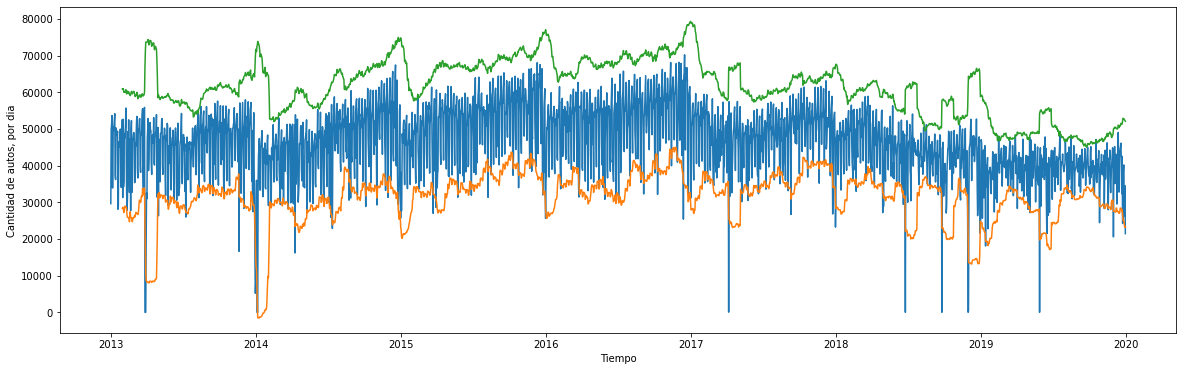

In [27]:
#Defino una ventana de 30 días

wind =30
sigma = 2

dataset_2013_2019["inferior"] = dataset_2013_2019.cantidad_pasos.rolling(window=wind)\
    .mean() - (sigma * dataset_2013_2019.cantidad_pasos.rolling(window=wind).std())
dataset_2013_2019["superior"] = dataset_2013_2019.cantidad_pasos.rolling(window=wind)\
    .mean() + (sigma * dataset_2013_2019.cantidad_pasos.rolling(window=wind).std())

dataset_2013_2019['anom']=dataset_2013_2019.apply(lambda x: x['cantidad_pasos'] if (x['cantidad_pasos'] <= x['inferior'] or x['cantidad_pasos']>=x['superior'] ) else 0,axis=1)

plt.figure(figsize = (20,6))
plt.plot(dataset_2013_2019.index, dataset_2013_2019.cantidad_pasos)
plt.plot(dataset_2013_2019.index, dataset_2013_2019.inferior)
plt.plot(dataset_2013_2019.index, dataset_2013_2019.superior)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

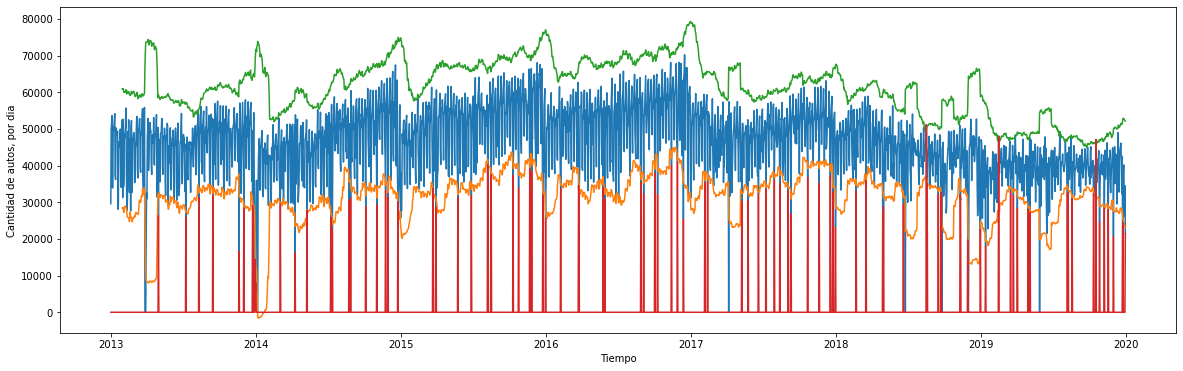

In [28]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2013_2019.index, dataset_2013_2019.cantidad_pasos)
plt.plot(dataset_2013_2019.index, dataset_2013_2019.inferior)
plt.plot(dataset_2013_2019.index, dataset_2013_2019.superior)
plt.plot(dataset_2013_2019.index, dataset_2013_2019.anom)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [29]:
dataset_2013_2019.cantidad_pasos=dataset_2013_2019.apply(lambda x: x['cantidad_pasos'] if (x['anom']==0) else np.nan,axis=1)
dataset_2013_2019.cantidad_pasos=dataset_2013_2019.cantidad_pasos.replace(0,np.nan)
dataset_2013_2019.cantidad_pasos=dataset_2013_2019.cantidad_pasos.replace(1,np.nan)
dataset_2013_2019.loc[dataset_2013_2019.anom!=0]

,cantidad_pasos,inferior,superior,anom
fecha2,,,,
2013-05-01,NaN,31037.464167,59266.602500,26313.0
2013-07-09,NaN,27224.162436,57200.637564,25962.0
2013-08-11,NaN,32567.704682,55562.561984,31238.0
2013-09-15,NaN,32381.720847,60776.812486,31827.0
2013-11-20,NaN,31563.430976,62765.569024,16620.0
...,...,...,...,...
2019-11-18,NaN,28343.912500,48437.754167,27937.0
2019-12-01,NaN,27530.375633,49940.291033,20553.0
2019-12-24,NaN,26616.516603,52186.016730,24220.0


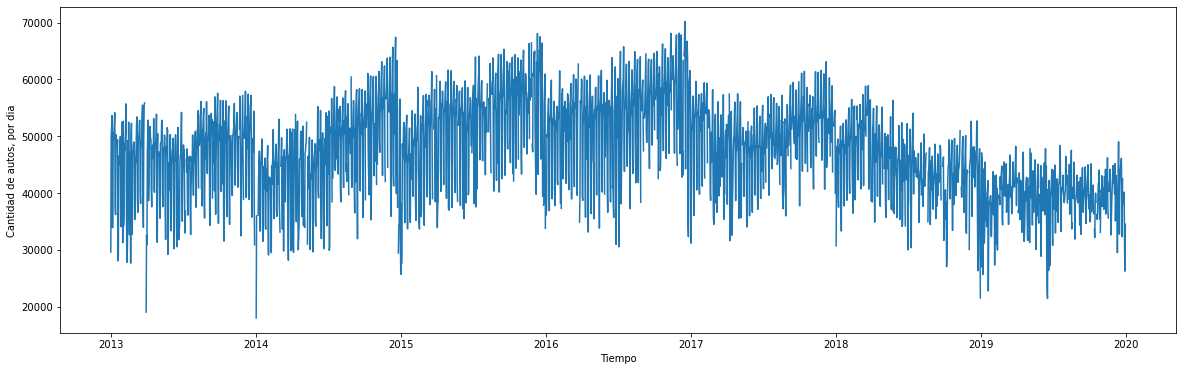

In [30]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2013_2019.index, dataset_2013_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [31]:
dataset_2013_2019.drop(['inferior','superior','anom'],axis=1,inplace=True)

print("El dataset tiene los siguientes valores nulos:")
dataset_2013_2019.isnull().sum()

El dataset tiene los siguientes valores nulos:


cantidad_pasos    109
dtype: int64

In [32]:
dataset_2013_2019 =dataset_2013_2019.interpolate()

print("El dataset de diario tiene los siguientes valores nulos:")
dataset_2013_2019.isnull().sum()

El dataset de diario tiene los siguientes valores nulos:


cantidad_pasos    0
dtype: int64

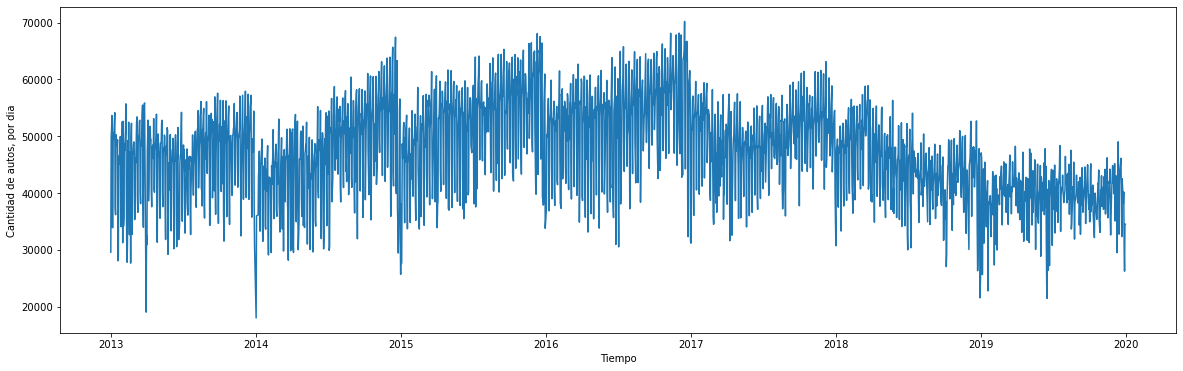

In [33]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2013_2019.index, dataset_2013_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

A continuación voy a unir la variable "tipo de vehículo" y voy a imputar valores nulos. Voy a utilizar el metodo pad de fillna para reemplazar los valores nulos con el valor del día anterior. Luego se transformará en variable numérica.

In [34]:
dataset_2013_2019['tipo_vehiculo']=tipo_vehiculo

dataset_2013_2019.head()

,cantidad_pasos,tipo_vehiculo
fecha2,,
2013-01-01,29609.0,Pesado
2013-01-02,49858.0,Pesado
2013-01-03,51344.0,Pesado
2013-01-04,53640.0,Pesado
2013-01-05,33952.0,Pesado


In [35]:
dataset_2013_2019.isnull().sum().reset_index()

,index,0
0,cantidad_pasos,0
1,tipo_vehiculo,7


In [36]:
"""
Imputación de la variable tipo_vehículo utilizando el valor del día anterior y transformación en variable numérica.

"""

dataset_2013_2019['tipo_vehiculo'].fillna(method='pad', inplace=True)
dataset_2013_2019.isnull().sum().reset_index()

dataset_2013_2019.tipo_vehiculo=np.where(dataset_2013_2019.tipo_vehiculo=='Pesado',0,1)

dataset_2013_2019

,cantidad_pasos,tipo_vehiculo
fecha2,,
2013-01-01,29609.0,0
2013-01-02,49858.0,0
2013-01-03,51344.0,0
2013-01-04,53640.0,0
2013-01-05,33952.0,0
...,...,...
2019-12-27,40182.0,1
2019-12-28,30681.0,1
2019-12-29,26259.0,1


### Modelos autorregresivos

Voy a utilizar un método autorregresivo para utilizarlo en mis predicciones. Para este caso solamente utilizaré la variable cantidad_pasos.

In [37]:
senial=dataset_2013_2019.cantidad_pasos

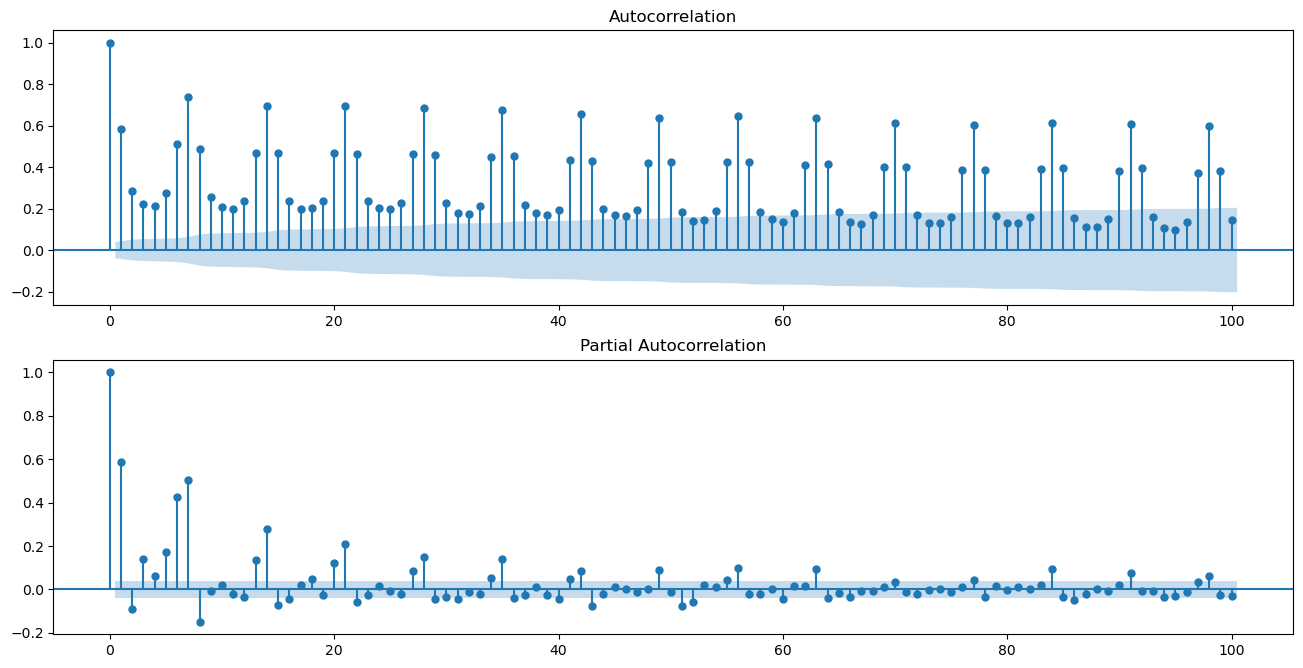

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,figsize=(16,8), dpi= 100)
plot_acf(senial, lags=100, ax=axes[0])
plot_pacf(senial, lags=100, ax=axes[1])
plt.show()

La autocorrelación utiliza la correlación de Pearson para ver la correlación de la serie con días anteriores, teniendo en cuenta relaciones directas e indirectas. La primera línea vale uno porque es con el mismo día. Luego observamos claramente como se preserva la estacionalidad, la presencia de un patrón de variación entre una semana y otra.

En la autocorrelación parcial, en la cual se quitan las relaciones indirectas, vemos como el flujo de un día de la semana va a depender del flujo del mismo día de la semana anterior y así sucesivamente. La misma va disminuyendo.

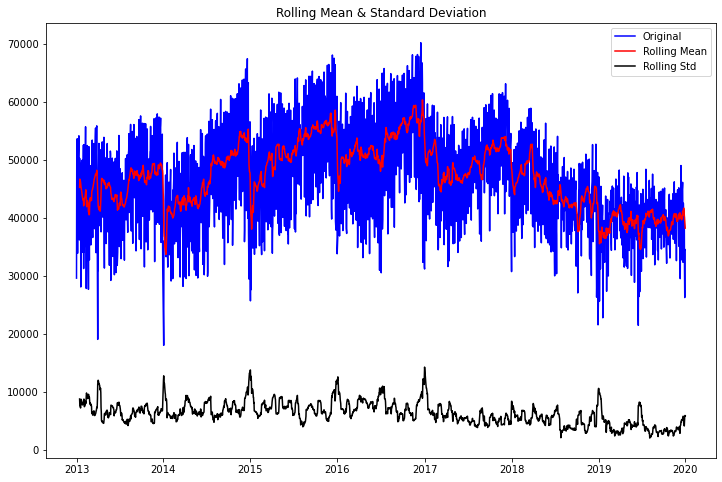

Results of Dickey-Fuller Test:
Test Statistic                   -1.998368
p-value                           0.287289
#Lags Used                       27.000000
Number of Observations Used    2528.000000
Critical Value (1%)              -3.432939
Critical Value (5%)              -2.862684
Critical Value (10%)             -2.567379
dtype: float64


In [39]:
resultado=test_stationarity(senial)

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas con el tiempo, es decir, su media y varianza.

Al comparar el estadístico ADF con los valores críticos, vemos que estos últimos son mas negativos, lo cual nos habla que la serie no es estacionaria. Esto a su vez se confirma con el valor del p-value (nos indica la fuerza con la que se rechaza la H0), que es mayor a 0.05, por lo cual no se rechaza la hipotesis nula, indicando con un 95% de probabilidad que la serie no es estacionaria.

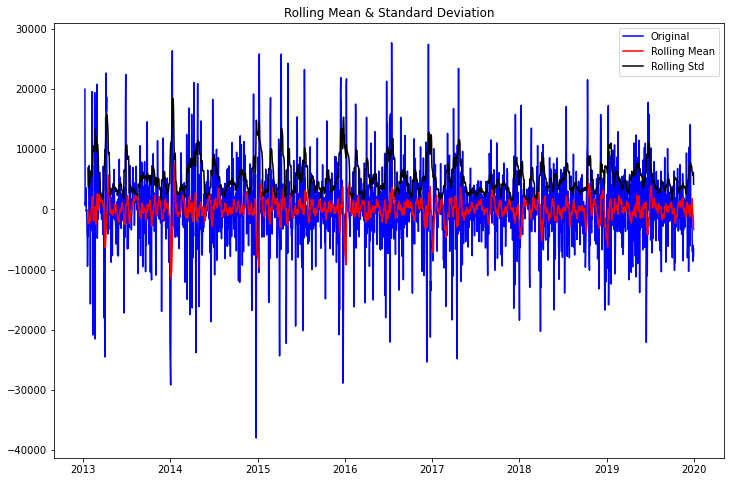

Results of Dickey-Fuller Test:
Test Statistic                -1.413452e+01
p-value                        2.302540e-26
#Lags Used                     2.700000e+01
Number of Observations Used    2.521000e+03
Critical Value (1%)           -3.432947e+00
Critical Value (5%)           -2.862687e+00
Critical Value (10%)          -2.567381e+00
dtype: float64


In [40]:
"""

Diferenciación de la serie de tiempo para transformarla en estacionaria

"""

senial_estacionaria=senial-senial.shift(7)
senial_estacionaria.dropna(inplace=True)
resultado=test_stationarity(senial_estacionaria)

La prueba de Dickey Fuller muestra que la serie ahora es estacionaria. Esto también se puede comprobar con los gráficos de autocorrelación y autocorrelación parcial.

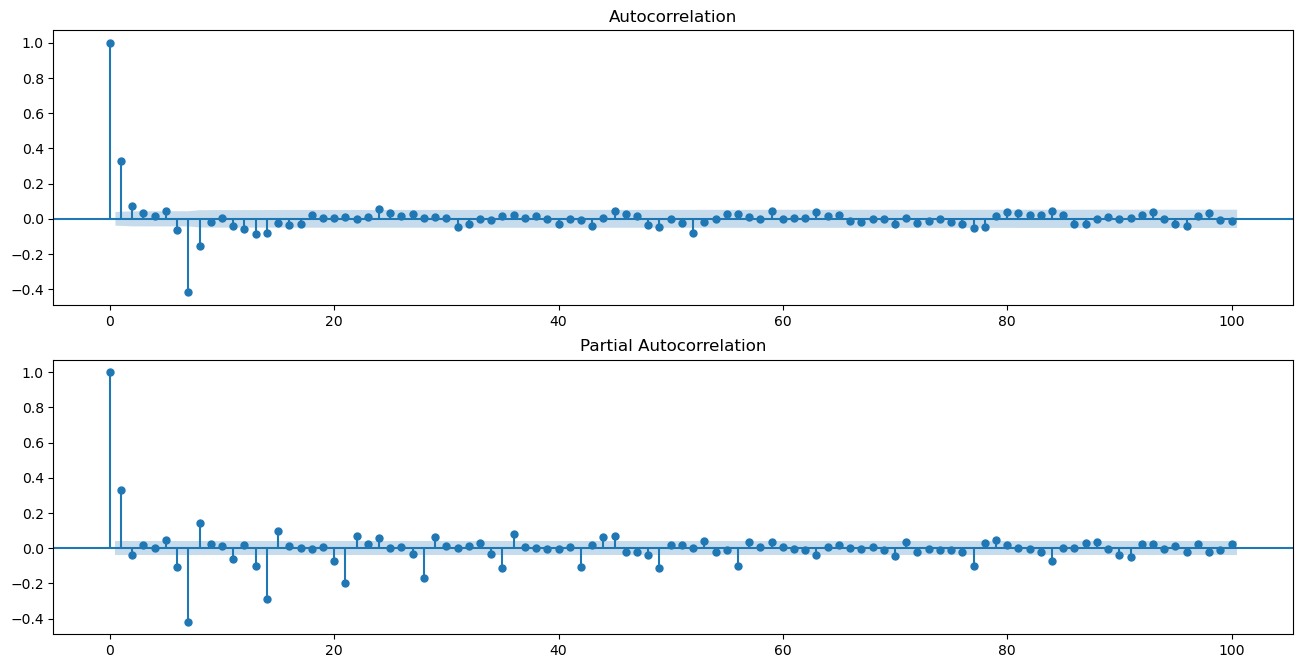

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,figsize=(16,8), dpi= 100)
plot_acf(senial_estacionaria, lags=100, ax=axes[0])
plot_pacf(senial_estacionaria, lags=100, ax=axes[1])
plt.show()

SARIMA (p, d, q) (P, D, Q, s) es un modelo de media móvil de autorregresión estacional donde:

AR (p): modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún rezago (o varios rezagos). El retraso máximo en el modelo se denomina p. Para determinar la p inicial, debe observar el gráfico PACF y encontrar el mayor retraso significativo después del cual la mayoría de los demás retrasos se vuelven insignificantes.

MA (q): modelo de media móvil. Sin entrar en demasiados detalles, modela el error de la serie temporal, nuevamente con el supuesto de que el error actual depende del anterior con cierto rezago, lo que se denomina q. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes. Combinemos nuestras primeras 4 letras:

AR (p) + MA (q) = ARMA (p, q) Lo que tenemos aquí es el modelo de media móvil autorregresiva. Si la serie es estacionaria, se puede aproximar con estas 4 letras. Continuemos.

I (d) : orden de integración. Este es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos primeras diferencias. La adición de esta letra a las cuatro nos da el modelo ARIMA que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales.

S (s): esto es responsable de la estacionalidad e iguala la duración del período de temporada de la serie Con esto, tenemos tres parámetros: (P, D, Q) P - orden de autorregresión para el componente estacional del modelo, que puede derivarse de PACF. Pero debe observar la cantidad de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 7 y vemos que los rezagos 7 y 14 son significativos en el PACF, eso significa que la P inicial debería ser 2.

Q - lógica similar usando la gráfica ACF en su lugar.

D - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si se aplicaron o no diferencias estacionales.

Ahora que sabemos cómo establecer los parámetros iniciales, echemos un vistazo al gráfico final una vez más y establezcamos los parámetros:

Se puede ver que ACT y PACT tienen un patrón cada 7 días, indicando que existe un patrón por semana. Hay un componente estacional fuerte por lo cual deberíamos usar SARIMA para tenerlo en cuenta.

p: es probable sea 7 ya que es el último rezago significativo en el PACF, después del cual, la mayoría de los demás no son significativos.

d: es igual a 1 porqye ya se ha diferenciado la serie previamente.

q:aproximadamente 7,  se ve en el ACF.

P: podría ser 2, ya que los retrasos 7 y 14 son algo significativos en el PACF.

D: nuevamente es igual a 1 porque realizamos la diferenciación estacional.

Q: es probablemente 1. El desfase 7 en ACF es significativo, mientras que el 14 no lo es.

In [42]:
N_train_sarima = 365*6+274 # cantidad de instancias que vamos a usar para entrenar.
N_test_sarima = 90 #cantidad de puntos que vamos a usar para evaluar

senial_train = senial[:N_train_sarima]
senial_test = senial[N_train_sarima:N_train_sarima+N_test_sarima]

In [43]:
senial_test

fecha2
2019-10-01    39669.000000
2019-10-02    34943.000000
2019-10-03    35054.000000
2019-10-04    43775.000000
2019-10-05    45150.000000
                  ...     
2019-12-25    39622.333333
2019-12-26    38168.000000
2019-12-27    40182.000000
2019-12-28    30681.000000
2019-12-29    26259.000000
Freq: D, Name: cantidad_pasos, Length: 90, dtype: float64

In [44]:
model=SARIMAX(senial_train,order=(5,1,1), seasonal_order=(1,1,0,7)).fit()

In [45]:
forecast=model.forecast(90)

In [46]:
forecast

2019-10-01    38880.075103
2019-10-02    41139.907413
2019-10-03    42318.212720
2019-10-04    45081.831763
2019-10-05    41442.162686
                  ...     
2019-12-25    41365.490679
2019-12-26    42672.083073
2019-12-27    45159.676645
2019-12-28    41697.400198
2019-12-29    37310.652590
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

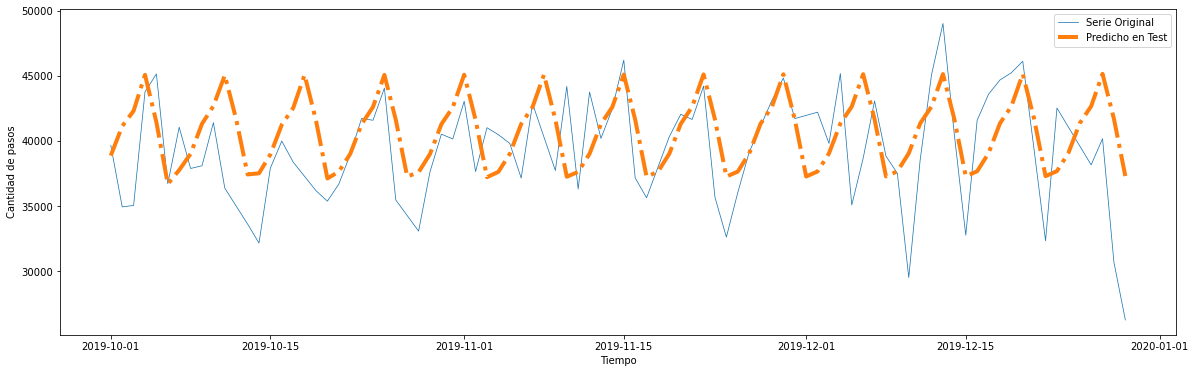

In [47]:
%matplotlib inline

plt.figure(figsize=(20,6))
plt.plot(senial.index[N_train_sarima:N_train_sarima+N_test_sarima], senial[N_train_sarima:N_train_sarima+N_test_sarima],lw = 0.75, label = 'Serie Original')
#plt.plot(senial.index[:N_train], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(senial.index[N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train_sarima:N_train_sarima+N_test_sarima], forecast,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [48]:
RMSE_test=np.sqrt(mean_squared_error(senial_test,forecast))
print("RMSE test single: :{:.2f}".format(RMSE_test))
r2_score_test=r2_score(senial_test,forecast)
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE test single: :4018.48
R2 score test single: 0.04


ANalizando las métricas obtenidas podemos afirmar que los resultados obtenidos no son los mejores. Aplicando otros modelos de anáisis supervisado  se obtuvieron mejores resultados teniendo en cuenta el RMSE como el R2 score. Claramente el modelo no generaliza correctamente.

## Modelo con Redes Neuronales N1

Vamos a configurar y entrenar una red neuronal básica utilizando solo variable cantidad_pasos

Es necesario hacer un preprocesado de los datos antes de someterlos a una Red Neuronal, teniendo en cuenta la variabilidad en la cantidad de pasos. 

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


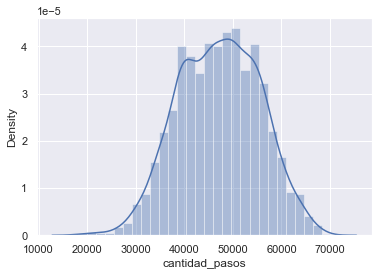

In [181]:
sns.set()
sns.distplot(dataset_2013_2019.cantidad_pasos)
plt.show()

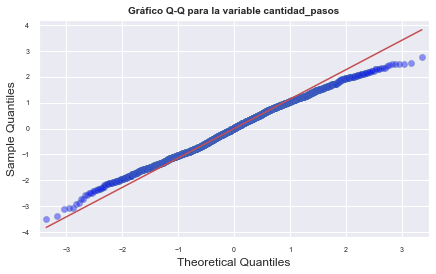

In [182]:
import statsmodels.api as sm
from scipy import stats

fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(dataset_2013_2019.cantidad_pasos,fit=True,line  = 'q',alpha = 0.4,lw=2,ax=ax)
ax.set_title('Gráfico Q-Q para la variable cantidad_pasos', fontsize = 10,fontweight = "bold")
ax.tick_params(labelsize = 7)

Como vemos en el gráfico de distribución, existen diferencias notables en el número de pasos, por lo cual deberíamos aplicar un escalamiento de los datos. 

El gráfico de cuantiles teóricos sirve para evaluar la normalidad de la distribución de una variable. Comparan los cuantiles de la distribución observada con los cuantiles teóricos de una distribución normal con la misma media y desviación estándar que los datos. Cuanto más se aproximen los datos a una normal, más alineados están los puntos entorno a la recta. Aunque existe una aproximación, podemos afirmar que la distribución no es normal. Como no existen datos extremos que la afecten, lo cual utilizaré MinMaxScaler para escalar los datos. Esto se aplicará únicamente sobra la variable cantidad_pasos


Con el fin de evitar que la información sobre la distribución del conjunto de test se filtre en el modelo, se debe ajustar el escalador solo en los datos de entrenamiento, luego estandarizar los conjuntos de entrenamiento y de prueba con ese escalador. Al ajustar el escalador en el conjunto de datos completo antes de dividirlo la información sobre el conjunto de test se usa para transformar el conjunto de entrenamiento.

In [304]:
senial_2013_2019=dataset_2013_2019.cantidad_pasos

In [305]:
look_back=28

N_train = 365*6+270- look_back # 3 años + 3 trimestres
N_test = 90 # 1 trimestre
N_total = N_train + N_test

train_data = senial_2013_2019[:N_train]
test_data = senial_2013_2019[-N_test:]

print("Train data : {} - Test data: {}".format(train_data.shape,test_data.shape))

Train data : (2432,) - Test data: (90,)


Para obtener el dataset de testeo, obtendré las últimas 28 observaciones del dataset de entrenamiento y las agregaré al dataset de testeo. Esto es importante a la hora de transformar el problema de series temporales en análisis supervisado, ya que se utilizarán los 28 días anteriores para predecir el 29, que es donde comienza en este caso el dataset de testeo.

In [306]:
test_data= pd.concat([train_data[-look_back:],test_data],axis=0)

Vamos a entrenar y transformar el escalador con el conjunto de entrenamiento y transformar el de testeo. Esto es para evitar que información del dataset de entrenamiento genere un sesgo en el de testeo

In [307]:
train_data

fecha2
2013-01-01    29609.0
2013-01-02    49858.0
2013-01-03    51344.0
2013-01-04    53640.0
2013-01-05    33952.0
               ...   
2019-08-25    31905.0
2019-08-26    38482.0
2019-08-27    38760.0
2019-08-28    39207.0
2019-08-29    39986.0
Freq: D, Name: cantidad_pasos, Length: 2432, dtype: float64

In [308]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled=scaler.transform(test_data.values.reshape(-1, 1))

In [309]:
train_scaled

array([[0.22202419],
       [0.61009218],
       [0.63857107],
       ...,
       [0.39740125],
       [0.40596792],
       [0.4208973 ]])

Como se vío en el Proyecto 03, con datos de series temporales, la secuencia de valores es importante. 

Voy a aplicar el mismo método de one step prediction, considerando nuevamente un lookback de 28 días. 

In [310]:
train_reframed = series_to_supervised(train_scaled , look_back, 1)
test_reframed = series_to_supervised(test_scaled , look_back, 1)

In [311]:
train_reframed.head(2)

,var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
28,0.222024,0.610092,0.638571,0.682573,0.305257,0.304529,0.623814,0.604247,0.624466,0.659020,0.692386,0.374097,0.348263,0.618046,0.60348,0.598440,0.580003,0.600452,0.192875,0.210679,0.545622,0.518101,0.546120,0.555013,0.612028,0.332107,0.307806,0.558961,0.558328
29,0.610092,0.638571,0.682573,0.305257,0.304529,0.623814,0.604247,0.624466,0.659020,0.692386,0.374097,0.348263,0.618046,0.603480,0.59844,0.580003,0.600452,0.192875,0.210679,0.545622,0.518101,0.546120,0.555013,0.612028,0.332107,0.307806,0.558961,0.558328,0.661722


In [312]:
X_train_scaled=train_reframed.drop(['var1(t)'],axis=1)
y_train_scaled=train_reframed[['var1(t)']]

X_test_scaled=test_reframed.drop(['var1(t)'],axis=1)
y_test_scaled=test_reframed[['var1(t)']]

print(X_train_scaled.shape,y_train_scaled.shape)
print(X_test_scaled.shape,y_test_scaled.shape)

(2404, 28) (2404, 1)
(90, 28) (90, 1)


Hacemos un reshape input para que sea de 3 dimensiones [samples, timesteps, features], requerido para tensorflow

In [313]:
X_train_nn = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_nn = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

### Entrenamiento y optimización de una red neuronal

Las redes neuronales son entrenadas utilizando el algoritmo de optimización por gradiente descendiente. Esto implica utilizar el estado actual del modelo para hacer una predicción, comparandola con los valores esperados y usando la diferencia para estimar el error de gradiente. Esto quiere decir que cuanto mas elementos de entrenamiento son utilizados, más precisa será la estimación y por lo tanto los pesos de la red serán ajustados de una manera que permita mejorar la performance del modelo. 

El numero de muestras de entrenamiento utilizadas para estimar el error de gradiente es llamado batch size.

Por otro lado, el número de epocas se refiere al número de veces en que el set de entrenamiento es pasado a través de la red para ajustar los pesos. Es un parámetro importante para evitar el overvitting.

Se utilizará GridSearchCV para encontrar los parámetros óptimos de una red neuronal.
En primer lugar es necesario determinar el learning rate, ya que utilizaré el optimizador SGD.
Luego también probaré otros optimizadores alternativos a Descenso de Gradiente Estocástico como Adam (Adaptive Moment Estimation) o AdaGrad(Adaptive Gradient Algorithm)

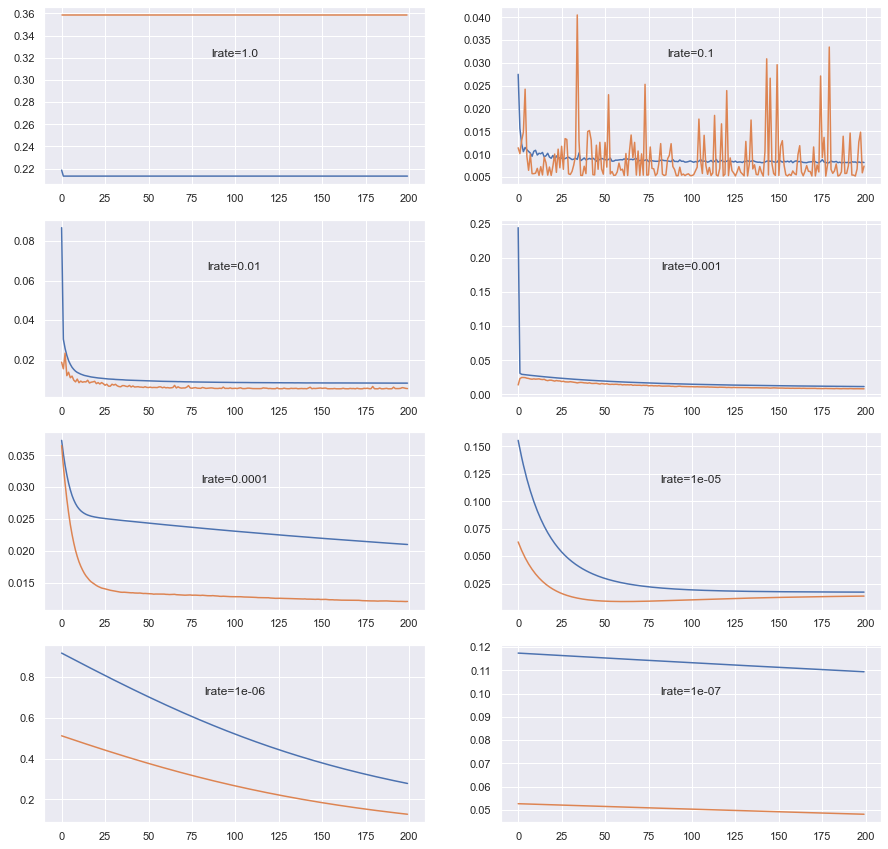

In [430]:
def entrenar_modelo(X_train_nn, y_train_scaler, X_test_nn, y_test_scaled, lrate):

    model = Sequential() 
    model.add(Dense(50, input_shape=(1,28), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    
    # Compilación
    opt = SGD(lr=lrate)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    # fit model
    
    history = model.fit(X_train_nn, y_train_scaler, validation_data=(X_test_nn, y_test_scaled), epochs=200, verbose=0)
    
    # plot learning curves
    
    plt.plot(history.history['mean_squared_error'], label='train')
    plt.plot(history.history['val_mean_squared_error'], label='test')
    plt.title('lrate='+str(lrate), pad=-50)
 
#learning rates

learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]

plt.figure(figsize=(15,15))
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    entrenar_modelo(X_train_nn, y_train_scaled, X_test_nn, y_test_scaled, learning_rates[i])

plt.show()

Con un learning rate de 0.1 se observa como el modelo aprende rápidamente pero vemos una gran cantidad de ruido en la señal de validación. Las predicciones son completamente alearorias.
El learning rate mas optimo es 0.0001, ya que con 0.00001 se observa claramente un problema de overfitting al aumentar el validation loss.

In [418]:
seed = 7
np.random.seed(seed)

def red_modelo():

    model = Sequential() 
    model.add(Dense(50, input_shape=(1,28), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=opt,metrics=['mean_squared_error'])
    return model


model = KerasRegressor(build_fn=red_modelo,verbose=0)

#Definición de hiperparámetros

batch_size = [2,4,6,8,10,15, 20, 30,40]
epochs = [30, 50, 100,150,200,250,300]


param_grid = dict(batch_size=batch_size, epochs=epochs)


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')


grid_result = grid.fit(X_train_nn, y_train_scaled)


print("El mejor es: %f con %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) con: %r" % (mean, stdev, param))

KeyboardInterrupt: 

Como se puede observar, el mejor resultado es con un batch size de 4 y 200 épocas. Se ha tenido que bajar el learning rate para evitar que el modelo aprenda demasiado rápido, evitando así saltarse los mínimos.

#### Entrenamiento con los mejores hiperparámetros

In [409]:
seed = 7
np.random.seed(seed)

model = Sequential() 
model.add(Dense(50, input_shape=(1,28), activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
300 40

In [410]:
modelo_1 = model.fit(X_train_nn , y_train_scaled,validation_data=(X_test_nn,y_test_scaled),epochs =200,batch_size=8)

Epoch 1/300
61/61 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0134
Epoch 2/300
61/61 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 3/300
61/61 [==============================] - 0s 905us/step - loss: 0.0210 - val_loss: 0.0112
Epoch 4/300
61/61 [==============================] - 0s 927us/step - loss: 0.0183 - val_loss: 0.0104
Epoch 5/300
61/61 [==============================] - 0s 964us/step - loss: 0.0176 - val_loss: 0.0101
Epoch 6/300
61/61 [==============================] - 0s 932us/step - loss: 0.0162 - val_loss: 0.0097
Epoch 7/300
61/61 [==============================] - 0s 898us/step - loss: 0.0153 - val_loss: 0.0101
Epoch 8/300
61/61 [==============================] - 0s 927us/step - loss: 0.0142 - val_loss: 0.0091
Epoch 9/300
61/61 [==============================] - 0s 930us/step - loss: 0.0132 - val_loss: 0.0096
Epoch 10/300
61/61 [==============================] - 0s 907us/step - loss: 0.0128 - val_loss: 

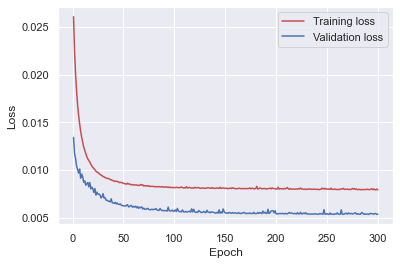

In [416]:
training_loss = modelo_1.history['loss']
test_loss= modelo_1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss,label='Training loss',color='r')
plt.plot(epoch_count, test_loss,color='b',label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Efectivamente podemos ver que el modelo ha aprendido a medida que aumentaban las épocas. Si bien 


In [412]:
import math 
train_score = model.evaluate(X_train_nn, y_train_scaled, verbose=0)
print('Puntuacion de entrenamiento: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(X_test_nn, y_test_scaled, verbose=0)
print('Puntuacion del test: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

Puntuacion de entrenamiento: 0.01 MSE (0.09 RMSE)
Puntuacion del test: 0.01 MSE (0.07 RMSE)


Para obtener las predicciones reales, debido a que los datos se encuentran escalados entre -1 y 1, se debe hacer la transformada inversa utilizando inverse_transform.

Esto se hace para train y test

In [413]:
y_train_pred=model.predict(X_train_nn)
y_test_pred=model.predict(X_test_nn)

actual_predictions_train = scaler.inverse_transform(np.array(y_train_pred).reshape(-1, 1))
real_train = scaler.inverse_transform(np.array(y_train_scaled).reshape(-1, 1))

actual_predictions_test = scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1))
real_test = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))

Se calcula el RMSE y R2_score

In [414]:
RMSE_train=np.sqrt(mean_squared_error(real_train,actual_predictions_train))
RMSE_test=np.sqrt(mean_squared_error(real_test,actual_predictions_test))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))

r2_score_train=r2_score(real_train,actual_predictions_train)
r2_score_test=r2_score(real_test,actual_predictions_test)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE train single: :4633.98
RMSE test single: :3817.85
R2 score train single: 0.69
R2 score test single: 0.15


Sin duda el modelo obtenido es mucho mejor que el planteado con SARIMA. Se ha conseguido una mejora tanto en el RMSE como en el R2_score. Sin embargo, este ultimo nos esta informando que el modelo aún presenta mucha variabilidad. Vamos a intentar agregando una variable como "tipo_vehiculo" a ver si mejora la performance

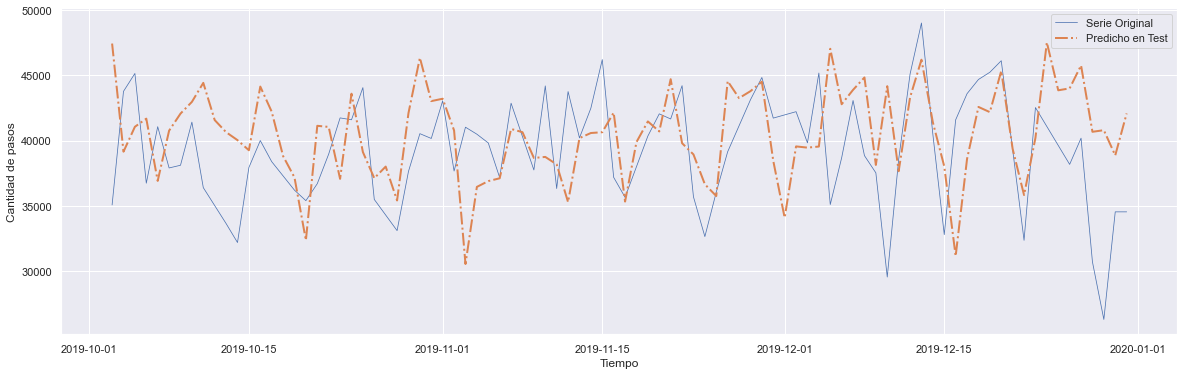

In [373]:
plt.figure(figsize=(20,6))
plt.plot(senial.index[-N_test:], senial[-N_test:],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[-N_test:], actual_predictions_test,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

El modelo, como se puede observar en la gráfica, sigue mas o menos el patrón de la señal de testeo.

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


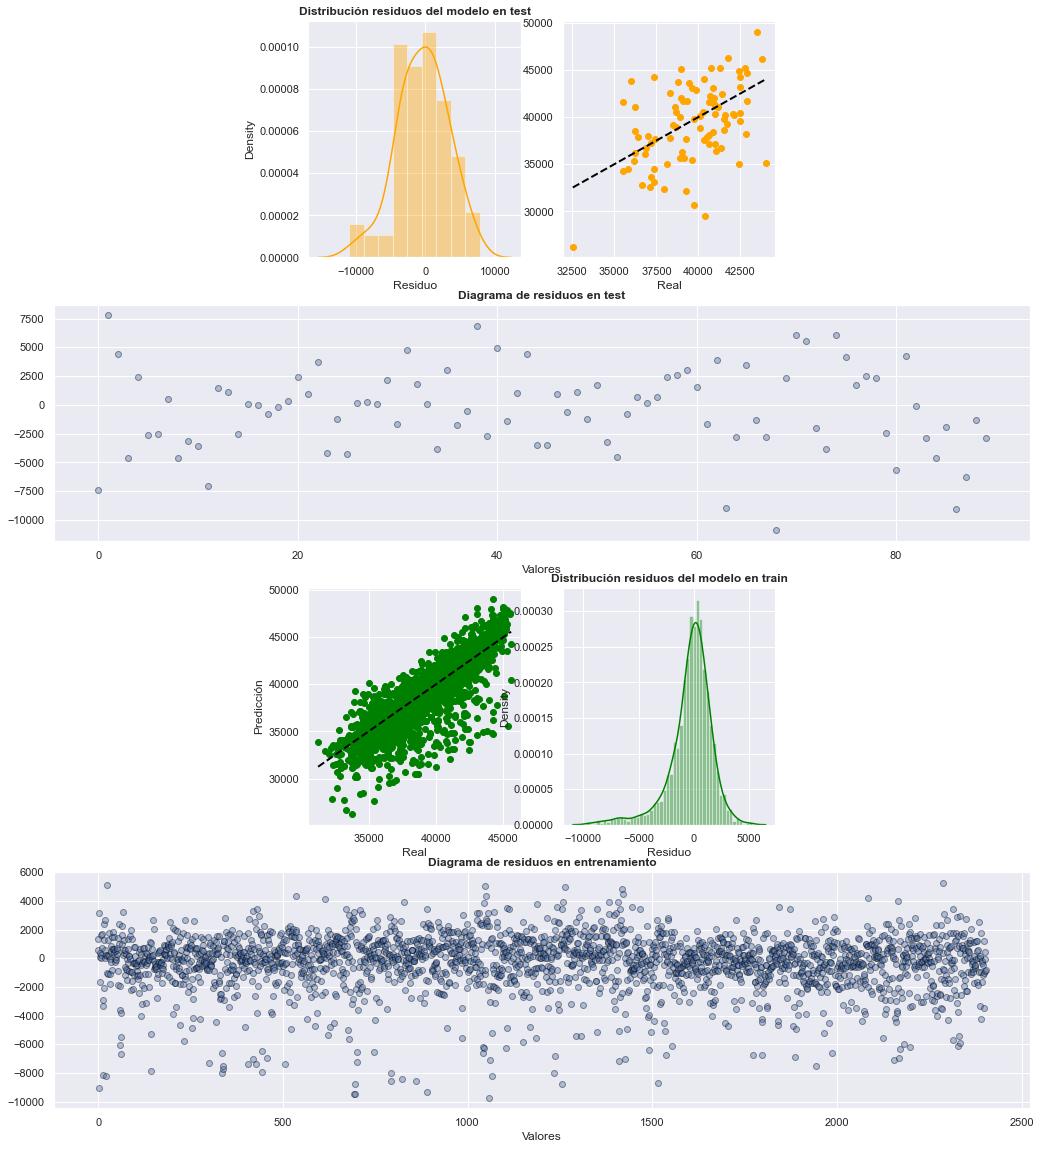

In [103]:
graficas_modelo(real_test,actual_predictions_test,real_train,actual_predictions_train)

La distribución de los residuos no siguen un comportamiento normal como es de esperar, lo cual se confirma con las métricas explicadas anteriormente.

## Red neuronal agregando variable "sentido"

In [220]:
dataset_2013_2019

,cantidad_pasos,tipo_vehiculo
fecha2,,
2013-01-01,29609.0,-1
2013-01-02,49858.0,-1
2013-01-03,51344.0,-1
2013-01-04,53640.0,-1
2013-01-05,33952.0,-1
...,...,...
2019-12-27,40182.0,1
2019-12-28,30681.0,1
2019-12-29,26259.0,1


In [221]:
look_back=28

N_train = 365*6+270- look_back # 3 años + 3 trimestres
N_test = 90 # 1 trimestre
N_total = N_train + N_test

train_data = dataset_2013_2019[:N_train]
test_data = dataset_2013_2019[-N_test:]

print("Train data : {} - Test data: {}".format(train_data.shape,test_data.shape))

Train data : (2432, 2) - Test data: (90, 2)


In [222]:
test_data= pd.concat([train_data[-look_back:],test_data],axis=0)

In [223]:
test_data

,cantidad_pasos,tipo_vehiculo
fecha2,,
2019-08-02,46468.0,1
2019-08-03,42150.0,1
2019-08-04,41603.0,1
2019-08-05,43174.0,1
2019-08-06,38276.0,1
...,...,...
2019-12-27,40182.0,1
2019-12-28,30681.0,1
2019-12-29,26259.0,1


In [224]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_scaled = scaler.fit_transform(train_data.cantidad_pasos.values.reshape(-1, 1))
test_scaled=scaler.transform(test_data.cantidad_pasos.values.reshape(-1, 1))

In [225]:
train_data.tipo_vehiculo=np.where(train_data.tipo_vehiculo==0,-1,train_data.tipo_vehiculo)
test_data.tipo_vehiculo=np.where(test_data.tipo_vehiculo==0,-1,test_data.tipo_vehiculo)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [226]:
train_scaled=np.hstack((train_scaled,train_data.tipo_vehiculo.values.reshape(-1,1)))

In [227]:
train_scaled

array([[-0.55595163, -1.        ],
       [ 0.22018437, -1.        ],
       [ 0.27714215, -1.        ],
       ...,
       [-0.20519749,  1.        ],
       [-0.18806416,  1.        ],
       [-0.15820541,  1.        ]])

In [228]:
test_scaled=np.hstack((test_scaled,test_data.tipo_vehiculo.values.reshape(-1,1)))

In [229]:
train_reframed = series_to_supervised(train_scaled , look_back, 1)
test_reframed = series_to_supervised(test_scaled , look_back, 1)

In [230]:
train_reframed

,var1(t-28),var2(t-28),var1(t-27),var2(t-27),var1(t-26),var2(t-26),var1(t-25),var2(t-25),var1(t-24),var2(t-24),var1(t-23),var2(t-23),var1(t-22),var2(t-22),var1(t-21),var2(t-21),var1(t-20),var2(t-20),var1(t-19),var2(t-19),var1(t-18),var2(t-18),var1(t-17),var2(t-17),var1(t-16),var2(t-16),var1(t-15),var2(t-15),var1(t-14),var2(t-14),var1(t-13),var2(t-13),var1(t-12),var2(t-12),var1(t-11),var2(t-11),var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
28,-0.555952,-1.0,0.220184,-1.0,0.277142,-1.0,0.365147,-1.0,-0.389486,-1.0,-0.390943,-1.0,0.247628,-1.0,0.208494,-1.0,0.248932,-1.0,0.318040,-1.0,0.384772,-1.0,-0.251806,-1.0,-0.303475,-1.0,0.236091,-1.0,0.206961,-1.0,0.196880,-1.0,0.160007,-1.0,0.200905,-1.0,-0.614251,-1.0,-0.578643,-1.0,0.091244,-1.0,0.036202,-1.0,0.092240,-1.0,0.110025,-1.0,0.224056,-1.0,-0.335786,-1.0,-0.384388,-1.0,0.117921,-1.0,0.116656,-1.0
29,0.220184,-1.0,0.277142,-1.0,0.365147,-1.0,-0.389486,-1.0,-0.390943,-1.0,0.247628,-1.0,0.208494,-1.0,0.248932,-1.0,0.318040,-1.0,0.384772,-1.0,-0.251806,-1.0,-0.303475,-1.0,0.236091,-1.0,0.206961,-1.0,0.196880,-1.0,0.160007,-1.0,0.200905,-1.0,-0.614251,-1.0,-0.578643,-1.0,0.091244,-1.0,0.036202,-1.0,0.092240,-1.0,0.110025,-1.0,0.224056,-1.0,-0.335786,-1.0,-0.384388,-1.0,0.117921,-1.0,0.116656,-1.0,0.323444,-1.0
30,0.277142,-1.0,0.365147,-1.0,-0.389486,-1.0,-0.390943,-1.0,0.247628,-1.0,0.208494,-1.0,0.248932,-1.0,0.318040,-1.0,0.384772,-1.0,-0.251806,-1.0,-0.303475,-1.0,0.236091,-1.0,0.206961,-1.0,0.196880,-1.0,0.160007,-1.0,0.200905,-1.0,-0.614251,-1.0,-0.578643,-1.0,0.091244,-1.0,0.036202,-1.0,0.092240,-1.0,0.110025,-1.0,0.224056,-1.0,-0.335786,-1.0,-0.384388,-1.0,0.117921,-1.0,0.116656,-1.0,0.323444,-1.0,-0.492554,-1.0
31,0.365147,-1.0,-0.389486,-1.0,-0.390943,-1.0,0.247628,-1.0,0.208494,-1.0,0.248932,-1.0,0.318040,-1.0,0.384772,-1.0,-0.251806,-1.0,-0.303475,-1.0,0.236091,-1.0,0.206961,-1.0,0.196880,-1.0,0.160007,-1.0,0.200905,-1.0,-0.614251,-1.0,-0.578643,-1.0,0.091244,-1.0,0.036202,-1.0,0.092240,-1.0,0.110025,-1.0,0.224056,-1.0,-0.335786,-1.0,-0.384388,-1.0,0.117921,-1.0,0.116656,-1.0,0.323444,-1.0,-0.492554,-1.0,0.326511,-1.0
32,-0.389486,-1.0,-0.390943,-1.0,0.247628,-1.0,0.208494,-1.0,0.248932,-1.0,0.318040,-1.0,0.384772,-1.0,-0.251806,-1.0,-0.303475,-1.0,0.236091,-1.0,0.206961,-1.0,0.196880,-1.0,0.160007,-1.0,0.200905,-1.0,-0.614251,-1.0,-0.578643,-1.0,0.091244,-1.0,0.036202,-1.0,0.092240,-1.0,0.110025,-1.0,0.224056,-1.0,-0.335786,-1.0,-0.384388,-1.0,0.117921,-1.0,0.116656,-1.0,0.323444,-1.0,-0.492554,-1.0,0.326511,-1.0,-0.381360,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,-0.176834,1.0,-0.221373,1.0,-0.203013,1.0,-0.161348,1.0,-0.138772,1.0,0.090247,1.0,-0.075260,1.0,-0.096226,1.0,-0.036011,1.0,-0.223749,1.0,-0.123862,1.0,-0.023975,1.0,-0.110658,1.0,-0.197340,1.0,0.036854,1.0,-0.299680,1.0,-0.178827,1.0,-0.073420,1.0,-0.132870,1.0,0.131451,1.0,-0.399912,1.0,-0.360739,1.0,-0.276874,1.0,-0.193009,1.0,-0.115315,1.0,-0.193469,1.0,0.051113,1.0,-0.232412,1.0,-0.467947,1.0
2428,-0.221373,1.0,-0.203013,1.0,-0.161348,1.0,-0.138772,1.0,0.090247,1.0,-0.075260,1.0,-0.096226,1.0,-0.036011,1.0,-0.223749,1.0,-0.123862,1.0,-0.023975,1.0,-0.110658,1.0,-0.197340,1.0,0.036854,1.0,-0.299680,1.0,-0.178827,1.0,-0.073420,1.0,-0.132870,1.0,0.131451,1.0,-0.399912,1.0,-0.360739,1.0,-0.276874,1.0,-0.193009,1.0,-0.115315,1.0,-0.193469,1.0,0.051113,1.0,-0.232412,1.0,-0.467947,1.0,-0.215853,1.0
2429,-0.203013,1.0,-0.161348,1.0,-0.138772,1.0,0.090247,1.0,-0.075260,1.0,-0.096226,1.0,-0.036011,1.0,-0.223749,1.0,-0.123862,1.0,-0.023975,1.0,-0.110658,1.0,-0.197340,1.0,0.036854,1.0,-0.299680,1.0,-0.178827,1.0,-0.073420,1.0,-0.132870,1.0,0.13

Al agregar una variable, es esperable tener ahora el doble de variables (28x2=56) mas las dos en t.

In [231]:
X_train_scaled=train_reframed.drop(['var2(t)','var1(t)'],axis=1)
y_train_scaled=train_reframed[['var1(t)']]

X_test_scaled=test_reframed.drop(['var2(t)','var1(t)'],axis=1)
y_test_scaled=test_reframed[['var1(t)']]

print(X_train_scaled.shape,y_train_scaled.shape)
print(X_test_scaled.shape,y_test_scaled.shape)

(2404, 56) (2404, 1)
(90, 56) (90, 1)


In [232]:
X_train_nn = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_nn = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [295]:
seed = 7
np.random.seed(seed)

def red_modelo():

    model = Sequential() 
    model.add(Dense(50, input_shape=(1,56), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model


model = KerasRegressor(build_fn=red_modelo,verbose=0)

#Definición de hiperparámetros

batch_size = [2,4,6,8,10,15, 20, 30,40]
epochs = [30, 50, 100,150,200,250,300]

param_grid = dict(batch_size=batch_size, epochs=epochs)


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5,scoring='r2')


grid_result = grid.fit(X_train_nn, y_train_scaled)


print("El mejor es: %f con %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) con: %r" % (mean, stdev, param))

El mejor es: 0.519715 con {'batch_size': 20, 'epochs': 50}
0.476571 (0.209526) con: {'batch_size': 2, 'epochs': 30}
0.429588 (0.202328) con: {'batch_size': 2, 'epochs': 50}
0.390549 (0.294313) con: {'batch_size': 2, 'epochs': 100}
0.334671 (0.333021) con: {'batch_size': 2, 'epochs': 150}
0.275782 (0.380375) con: {'batch_size': 2, 'epochs': 200}
0.252971 (0.381387) con: {'batch_size': 2, 'epochs': 250}
0.185936 (0.474398) con: {'batch_size': 2, 'epochs': 300}
0.473449 (0.175323) con: {'batch_size': 4, 'epochs': 30}
0.465517 (0.208477) con: {'batch_size': 4, 'epochs': 50}
0.442335 (0.240269) con: {'batch_size': 4, 'epochs': 100}
0.385396 (0.338092) con: {'batch_size': 4, 'epochs': 150}
0.246382 (0.501454) con: {'batch_size': 4, 'epochs': 200}
0.304772 (0.370887) con: {'batch_size': 4, 'epochs': 250}
0.233726 (0.436145) con: {'batch_size': 4, 'epochs': 300}
0.491108 (0.226700) con: {'batch_size': 6, 'epochs': 30}
0.413191 (0.360565) con: {'batch_size': 6, 'epochs': 50}
0.446358 (0.242393)

In [296]:
seed = 7
np.random.seed(seed)

model = Sequential() 
model.add(Dense(50, input_shape=(1,56), activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))


model.compile(loss='mean_squared_error', optimizer='Adam')

In [297]:
modelo_1 = model.fit(X_train_nn , y_train_scaled,validation_data=(X_test_nn,y_test_scaled),epochs =30, batch_size=6)

Epoch 1/30
401/401 [==============================] - 1s 784us/step - loss: 0.0584 - val_loss: 0.0213
Epoch 2/30
401/401 [==============================] - 0s 592us/step - loss: 0.0413 - val_loss: 0.0208
Epoch 3/30
401/401 [==============================] - 0s 596us/step - loss: 0.0370 - val_loss: 0.0240
Epoch 4/30
401/401 [==============================] - 0s 593us/step - loss: 0.0332 - val_loss: 0.0240
Epoch 5/30
401/401 [==============================] - 0s 578us/step - loss: 0.0353 - val_loss: 0.0215
Epoch 6/30
401/401 [==============================] - 0s 577us/step - loss: 0.0324 - val_loss: 0.0209
Epoch 7/30
401/401 [==============================] - 0s 619us/step - loss: 0.0349 - val_loss: 0.0229
Epoch 8/30
401/401 [==============================] - 0s 601us/step - loss: 0.0319 - val_loss: 0.0219
Epoch 9/30
401/401 [==============================] - 0s 583us/step - loss: 0.0308 - val_loss: 0.0203
Epoch 10/30
401/401 [==============================] - 0s 533us/step - loss: 0.032

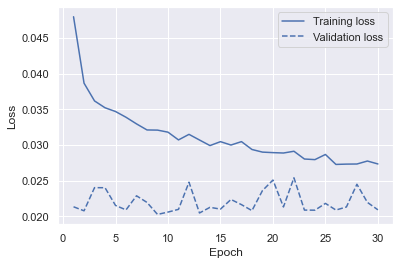

In [299]:
training_loss = modelo_1.history['loss']
test_loss= modelo_1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss,label='Training loss')
plt.plot(epoch_count, test_loss, 'r--',color='b',label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [300]:
np.array(y_train_scaled['var1(t)']).reshape(-1,1)

array([[ 0.11665613],
       [ 0.3234443 ],
       [-0.49255448],
       ...,
       [-0.20519749],
       [-0.18806416],
       [-0.15820541]])

In [301]:
y_train_pred=model.predict(X_train_nn)
y_test_pred=model.predict(X_test_nn)

actual_predictions_train = scaler.inverse_transform(np.array(y_train_pred))
real_train = scaler.inverse_transform(np.array(y_train_scaled['var1(t)']).reshape(-1,1))

actual_predictions_test = scaler.inverse_transform(np.array(y_test_pred))
real_test = scaler.inverse_transform(np.array(y_test_scaled['var1(t)']).reshape(-1,1))

In [302]:
RMSE_train=np.sqrt(mean_squared_error(real_train,actual_predictions_train))
RMSE_test=np.sqrt(mean_squared_error(real_test,actual_predictions_test))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))

r2_score_train=r2_score(real_train,actual_predictions_train)
r2_score_test=r2_score(real_test,actual_predictions_test)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE train single: :4137.16
RMSE test single: :3771.38
R2 score train single: 0.75
R2 score test single: 0.17


C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


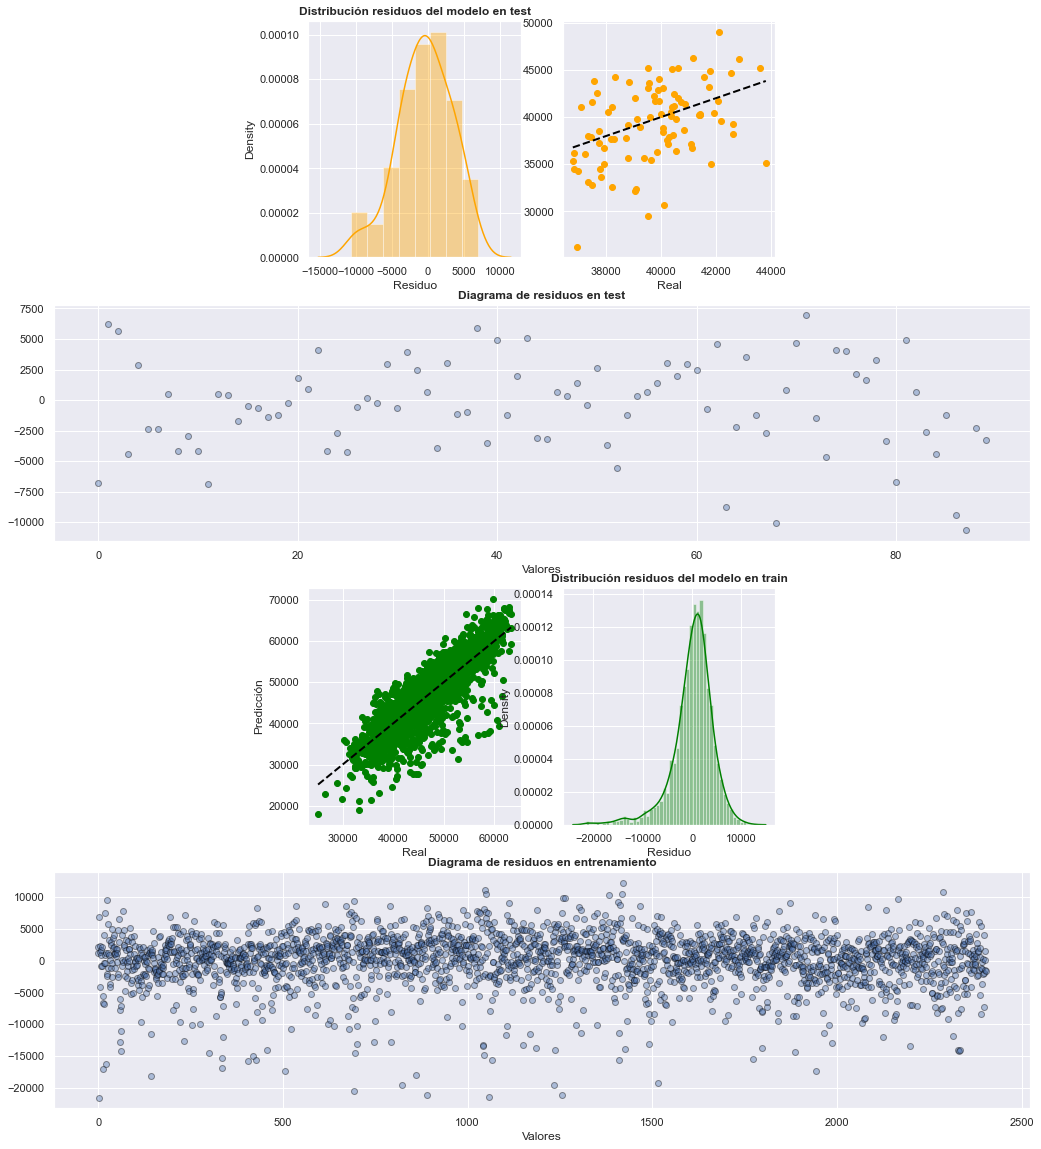

In [303]:
graficas_modelo(real_test,actual_predictions_test,real_train,actual_predictions_train)

## LSTM

Las redes neuronales Long short-term memory (LSTM) son redes neuronales artificicales recurrentes cuya arquitectura es usada en el campo del deep learning. A diferencia de las standard feedforward neural networks, LSTM tiene conexiones de retroalimentación. Tienen capacidad de memoria, característica que las hacen extremadamente útiles para lidiar con series temporales.

In [246]:
from keras.layers import LSTM
from keras.layers import Dropout


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1,look_back)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [247]:
modelo_2 = model.fit(X_train_nn , y_train_scaled,epochs = 100, batch_size=64)

Epoch 1/100
38/38 [==============================] - 5s 4ms/step - loss: 0.1132
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0375
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0342
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0329
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 11/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 12/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 13/100
38/38 [=================

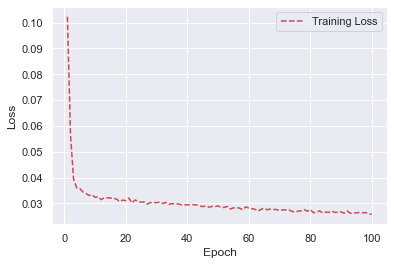

In [248]:
training_loss = modelo_2.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [249]:
y_train_pred=model.predict(X_train_nn)
y_test_pred=model.predict(X_test_nn)

actual_predictions_train = scaler.inverse_transform(np.array(y_train_pred).reshape(-1, 1))
real_train = scaler.inverse_transform(np.array(y_train_scaled).reshape(-1, 1))

actual_predictions_test = scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1))
real_test = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))

In [250]:
RMSE_train=np.sqrt(mean_squared_error(real_train,actual_predictions_train))
RMSE_test=np.sqrt(mean_squared_error(real_test,actual_predictions_test))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))

r2_score_train=r2_score(real_train,actual_predictions_train)
r2_score_test=r2_score(real_test,actual_predictions_test)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

RMSE train single: :1757.60
RMSE test single: :3587.80
R2 score train single: 0.77
R2 score test single: 0.25


In [ ]:
tensorflow.random.set_seed(2)

model = Sequential() 
model.add(Dense(50, input_shape=(1,look_back), activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='Adam', )

In [ ]:
senial.index[-N_test+-2:]

In [ ]:
test_data[28:]

In [ ]:
tensorflow.random.set_seed(2)

visible = Input(shape=(28))
hidden1 = Dense(50, activation='relu')(visible)
output = Dense(1)(hidden1)
model = Model(inputs=visible, outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history=model.fit(X_train_normalized, X_train_normalized, validation_data=(X_test_normalized, y_test_normalized),epochs=100, batch_size=4, verbose=2)

In [ ]:
# Estimacion del rendimiento del modelo

import math 
train_score = model.evaluate(X_train_single, y_train_single, verbose=0)
print('Puntuacion de entrenamiento: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(X_test_single, y_test_single, verbose=0)
print('Puntuacion del test: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

In [ ]:
y_train_pred=model.predict(X_train_single)
y_test_pred=model.predict(X_test_single)

In [ ]:
RMSE_train=np.sqrt(mean_squared_error(y_train_single,y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test_single,y_test_pred))
print("RMSE train single: :{:.2f}".format(RMSE_train))
print("RMSE test single: :{:.2f}".format(RMSE_test))
r2_score_train=r2_score(y_train_single,y_train_pred)
r2_score_test=r2_score(y_test_single,y_test_pred)
print("R2 score train single: {:.2f}".format(r2_score_train))
print("R2 score test single: {:.2f}".format(r2_score_test))

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [ ]:
graficas_modelo(y_test_single.reshape(-1,1),y_test_pred.reshape(-1,1),y_train_single.reshape(-1,1),y_train_pred.reshape(-1,1))